## Jax implementation of Jeffreys prior
for Ensemble Refinement and Force-Field Fitting

In [1]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../../3_alphabetagamma/')

In [3]:
from MDRefine.MDRefine import load_data, normalize_observables, minimizer, unwrap_2dict, loss_function
from basic_functions_bayesian import local_density, run_Metropolis

log det: some numerical technicalities to improve the calculations?

numerical stability? decompose the matrix... QR decomposition

https://github.com/b45ch1/algopy/issues/40



look at the Kish size (or the relative entropy) during the MC sampling

### 1. load data

In [15]:
infos = {'global': {
    'path_directory': '../../3_alphabetagamma/MDRefine/tests/DATA_test',
    'system_names': ['AAAA'],  # , 'CAAU'],  # , 'CCCC', 'GACC', 'UUUU', 'UCAAUC'],
    'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J'],#, 'NOEs'],# , ('uNOEs', '<')],
    'forward_qs': ['backbone1_gamma', 'backbone2_beta_epsilon','sugar'],
    # 'obs': ['NOEs'],#, 'uNOEs'],
    'forward_coeffs': 'original_fm_coeffs'}}

stride = 1

In [16]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs=None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [17]:
infos['global']['forward_model'] = forward_model_fun

In [18]:
infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha']

def ff_correction(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
# infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [19]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
done


### 2. normalize observables and find the optimal solution at given $\alpha$

In [9]:
name_mol = 'AAAA'

normalization: just once, at the beginning of Metropolis sampling

in order to simplify a pre-factor in the Jeffreys prior

In [10]:
out = normalize_observables(data.mol[name_mol].gexp, data.mol[name_mol].g, weights=data.mol[name_mol].weights)

data.mol[name_mol].g = out[0]
data.mol[name_mol].gexp = out[1]
data.mol[name_mol].normg_mean = out[2]
data.mol[name_mol].normg_std = out[3]

In [11]:
result = minimizer(data, alpha=1)  # this will be used in the next section, n.3

#### compute determinant of the covariance matrix

In [12]:
weights = data.mol[name_mol].weights

In [13]:
measures = {}
covs = {}

In [16]:
measures['obs 0'], covs['obs 0'] = local_density(data.mol[name_mol].g, weights)


[[ 1.00000000e+00 -2.91498850e-01  1.73594747e-02 -4.53315632e-02
  -8.68440371e-02  7.01763820e-03  1.35289826e-02 -5.67201989e-03
  -2.12604890e-02 -1.26144317e-01 -7.98149428e-03  9.67349036e-02
  -2.98235484e-02 -1.99353755e-02  4.04129562e-02  1.66564137e-02
  -2.64049318e-02 -1.47018494e-01 -2.03940453e-02  1.53929277e-01
  -5.33495096e-02 -1.37487889e-02  5.86923320e-02 -1.25892202e-02
   3.35420442e-03  1.67660379e-02 -5.17020752e-02  3.45277706e-02]
 [-2.91498850e-01  1.00000000e+00 -5.13350802e-02  3.61688638e-03
   1.10006885e-02  1.32556103e-02  1.35225894e-02 -4.22561962e-02
   5.06656724e-02 -1.44038306e-02  1.90652559e-02  4.42191136e-02
   1.24388622e-02  1.56454302e-02 -3.01205734e-02 -5.58492501e-02
   4.54857296e-02 -5.68326132e-02 -6.93227215e-03 -7.26338380e-03
   8.71304524e-03 -3.07114800e-02 -8.96592706e-03 -4.27769755e-02
  -1.38977321e-02  8.69895633e-03  4.36587278e-02 -5.23212458e-02]
 [ 1.73594747e-02 -5.13350802e-02  1.00000000e+00 -4.01192781e-01
  -5.425

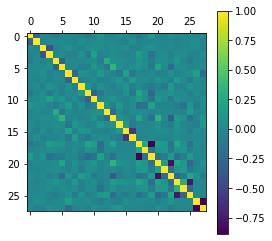

In [17]:
print(covs['obs 0'])
print(measures['obs 0'])

plt.matshow(covs['obs 0'])
plt.colorbar()

In [18]:
ff_correction = data.mol[name_mol].ff_correction

f = data.mol[name_mol].f
fun_forces = jax.jacfwd(ff_correction, argnums=0)
pars = np.ones(2)

measures['ff 0'], covs['ff 0'] = local_density((fun_forces, pars, f), weights)

[[ 2.52710053 -0.0132658 ]
 [-0.0132658   0.46250783]]
1.0810309008931311


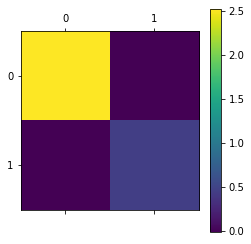

In [19]:
print(covs['ff 0'])
print(measures['ff 0'])

plt.matshow(covs['ff 0'])
plt.colorbar()

In [20]:
vars(result)

result.min_lambdas['AAAA']['backbone1_gamma_3J']

DeviceArray([-0.24557249,  0.1631482 , -0.11428702,  0.60595795,
             -0.11922997,  0.01015984,  0.42329455,  0.040694  ],            dtype=float64)

In [21]:
weights_new = result.weights_new[name_mol]

In [22]:
measures['obs opt'], covs['obs opt'] = local_density(data.mol[name_mol].g, weights_new)

In [23]:
# notice this is the force-field correction with the reweighted ensemble from Ensemble Refinement
# pars are arbitrarily chosen (they should be zero)
measures['ff opt'], covs['ff opt'] = local_density((fun_forces, pars, f), weights_new)

0.017470540394905604 2.357228142673416e-05


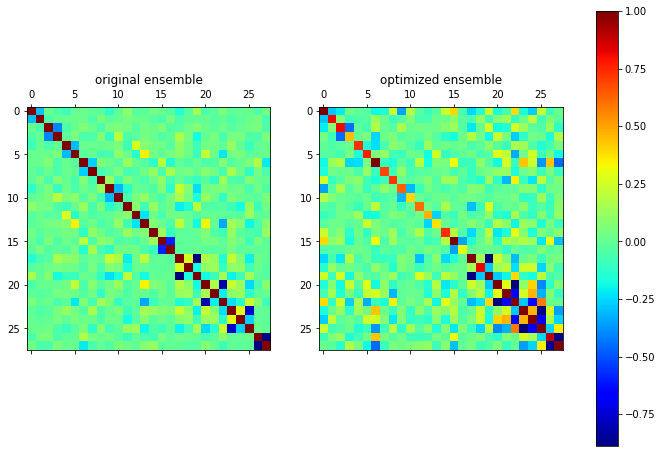

In [24]:
# print(covs['obs opt'])
print(measures['obs 0'], measures['obs opt'])

fig, axs = plt.subplots(1, 2, figsize=(12, 8))

axs[0].matshow(covs['obs 0'], cmap='jet')
axs[0].set_title('original ensemble')

minim = np.min(covs['obs 0'])
maxim = np.max(covs['obs 0'])

im = axs[1].matshow(covs['obs opt'], cmap='jet', vmin=minim, vmax=maxim)
axs[1].set_title('optimized ensemble')

plt.colorbar(im, ax=axs.ravel().tolist())

### 3. sample the posterior at this given value of the hyperparameters
(only $\alpha$ is finite, $\alpha=1$)

In [25]:
from MDRefine.MDRefine import loss_function

In [26]:
lambdas = result.min_lambdas
result.loss

DeviceArray(4.93328183, dtype=float64)

In [27]:
flatten_lambda = []
for name_mol in data.properties.system_names:
    flatten_lambda = flatten_lambda + list(
        np.hstack([lambdas[name_mol][k] for k in data.mol[name_mol].n_experiments.keys()]))

flatten_lambda = np.array(flatten_lambda)

#### compute and plot

In [28]:
loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=flatten_lambda)

DeviceArray(4.93328183, dtype=float64)

In [29]:
out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=flatten_lambda, if_save=True)

vars(out)

out.weights_new['AAAA']

DeviceArray([1.79491449e-04, 2.69392746e-03, 1.47756027e-04, ...,
             8.03432949e-05, 4.74687891e-06, 2.88849296e-05],            dtype=float64)

In [30]:
result.weights_new['AAAA']

DeviceArray([1.79491449e-04, 2.69392746e-03, 1.47756027e-04, ...,
             8.03432949e-05, 4.74687891e-06, 2.88849296e-05],            dtype=float64)

ok, it's correct

In [31]:
new_lambdas = flatten_lambda + 0.01*np.random.normal(size=len(flatten_lambda))

out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=new_lambdas, if_save=True)

In [32]:
out.loss

DeviceArray(4.93221611, dtype=float64)

In [33]:
out.loss_explicit

DeviceArray(4.93653023, dtype=float64)

In [35]:
measure, cov = local_density(data.mol[name_mol].g, out.weights_new[name_mol])

np.log(measure)

-10.666043083098794

In [36]:
out.av_g['AAAA']

{'backbone1_gamma_3J': DeviceArray([ 0.52786533, -0.03381083, -0.10976658, -0.12174215,
              -0.0987409 , -0.04633177, -0.05016633,  0.08267685],            dtype=float64),
 'backbone2_beta_epsilon_3J': DeviceArray([ 0.62941241,  0.06251834, -0.35860612,  0.5659161 ,
              -0.14439856, -0.18033113,  0.77055272,  0.36608928,
              -0.43988604], dtype=float64),
 'sugar_3J': DeviceArray([-0.16465509, -0.40841087, -0.23695974, -0.04846503,
              -0.27264429, -0.13249168, -0.00335403, -0.17645258,
              -0.20191755, -0.32699119,  0.17602618], dtype=float64)}

In [37]:
values = []
avgs = []

for i in range(500):
    
    new_lambdas = flatten_lambda + 0.01*np.random.normal(size=len(flatten_lambda))

    out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=new_lambdas, if_save=True)
    measure, cov = local_density(data.mol[name_mol].g, out.weights_new[name_mol])

    values.append([out.loss_explicit, np.log(measure)])
    avgs.append(out.av_g['AAAA']['backbone1_gamma_3J'])

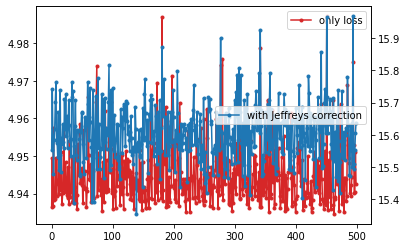

In [38]:
values = np.array(values)

fig, ax1 = plt.subplots()

ax1.plot(values[:, 0], '.-', color='tab:red', label='only loss')
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.plot(values[:, 0] - values[:, 1], '.-', color='tab:blue', label='with Jeffreys correction')

ax2.legend(loc='right')


In [39]:
avgs = np.array(avgs)

0.5293804202020245 0.5302214169956221
-0.025118647500268453 -0.025408390392013043
-0.1049851638017305 -0.10501229740427961
-0.12827035540770354 -0.1283242956128381
-0.1124713636864131 -0.11260133453779175
-0.042957559877606785 -0.0433797172367298
-0.03336418176460039 -0.03367435927540005
0.07516988020664653 0.07505750288496293


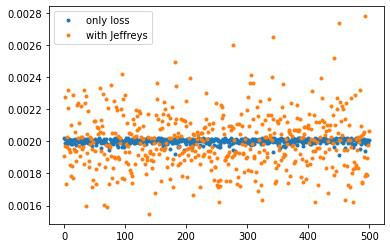

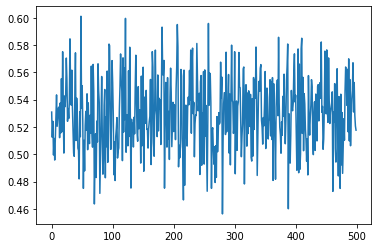

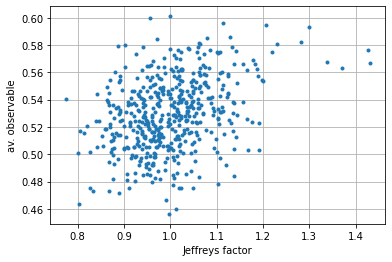

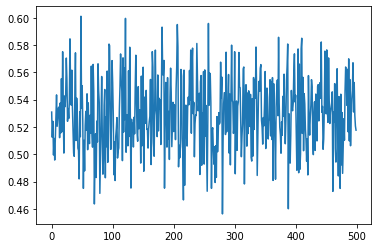

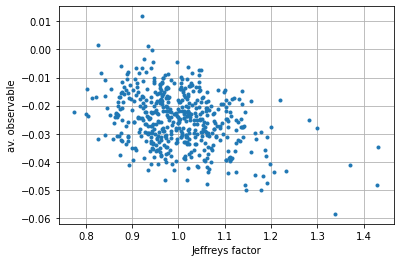

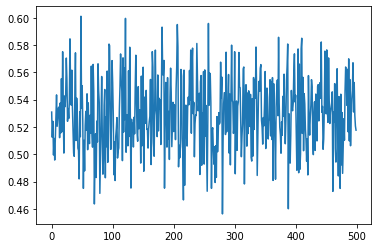

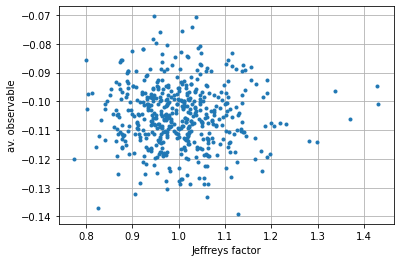

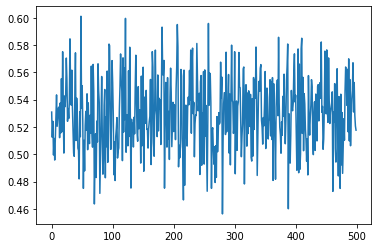

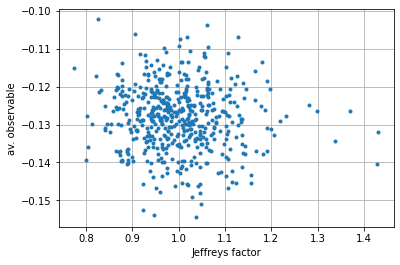

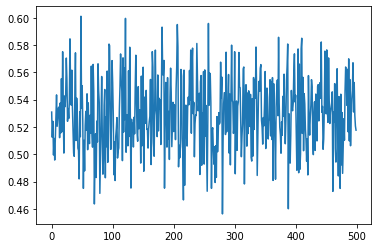

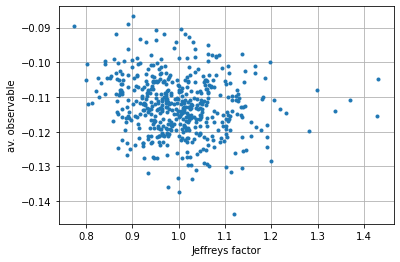

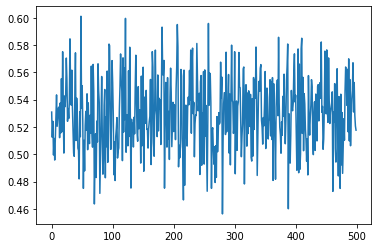

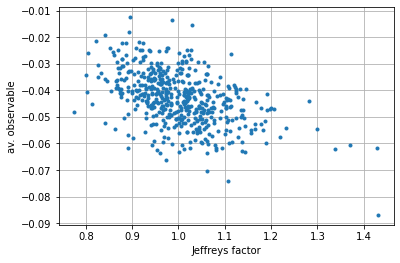

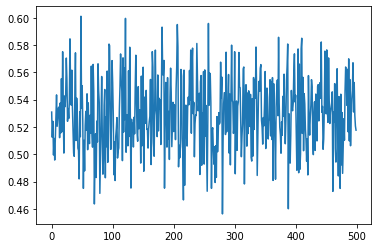

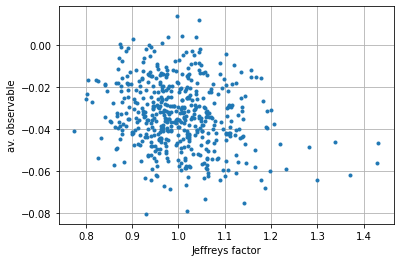

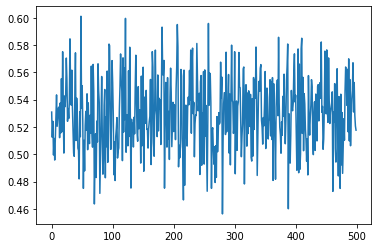

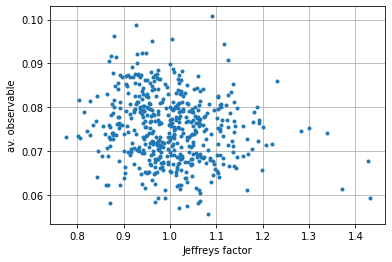

In [40]:
bayes_weight = np.exp(-values[:, 0])
bayes_weight = bayes_weight/np.sum(bayes_weight)

bayes_weight2 = np.exp(-values[:, 1])
bayes_weight2 = bayes_weight2/np.sum(bayes_weight2)

plt.plot(bayes_weight, '.', label='only loss')
plt.plot(bayes_weight2, '.', label='with Jeffreys')
plt.legend()

for i_obs in range(avgs.shape[1]):

    bayes_av = np.sum(bayes_weight*avgs[:, i_obs])
    bayes_av2 = np.sum(bayes_weight2*avgs[:, i_obs])

    plt.figure()
    plt.plot(avgs[:, 0])

    print(bayes_av, bayes_av2)

    plt.figure()
    plt.plot(bayes_weight2/bayes_weight, avgs[:, i_obs], '.')
    plt.xlabel('Jeffreys factor')
    plt.ylabel('av. observable')
    plt.grid()

#### Metropolis sampling

In [41]:
x0 = flatten_lambda

def proposal(x0, dx=0.01):
    x_new = x0 + dx*np.random.normal(size=len(x0))
    return x_new

proposal_full = {'fun': proposal, 'args': ([0.01])}

def energy_fun(lambdas, if_Jeffreys):
    
    out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=lambdas, if_save=True)
    
    energy = out.loss_explicit

    av_g = unwrap_2dict(out.av_g)[0]

    if if_Jeffreys:
        name_mol = list(out.weights_new.keys())[0]
        measure, cov = local_density(data.mol[name_mol].g, out.weights_new[name_mol], if_cholesky=True)
        energy -= np.log(measure)
    
    return energy, av_g

In [42]:
energy_function = {'fun': energy_fun, 'args': ([True])}
sampling_J = run_Metropolis(x0, proposal_full, energy_function, n_steps=500)

0
100
200
300
400


In [43]:
energy_function = {'fun': energy_fun, 'args': ([True])}
sampling_J = run_Metropolis(x0, proposal_full, energy_function, n_steps=500)

0
100
200
300
400


In [48]:
energy_function = {'fun': energy_fun, 'args': ([False])}
sampling_noJ = run_Metropolis(x0, proposal_full, energy_function, n_steps=500)

0
100
200
300
400


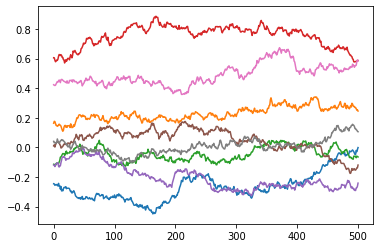

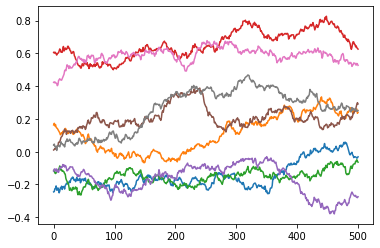

In [49]:
for i in range(8):

    plt.plot(sampling_J[0][:, i], '-', label='with Jeffreys prior')
    # plt.plot(sampling_noJ[0][:, i], '-', label='without Jeffreys prior')
    # plt.legend()

plt.savefig('../Figures/lambdas_J.pdf', format="pdf", bbox_inches="tight")

plt.figure()

for i in range(8):
    plt.plot(sampling_noJ[0][:, i], '-', label='without Jeffreys prior')
    # plt.legend()

plt.savefig('../Figures/lambdas_noJ.pdf', format="pdf", bbox_inches="tight")

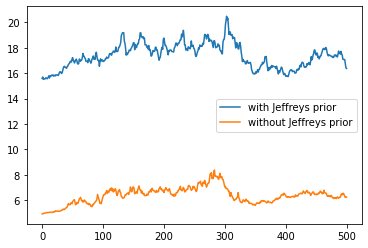

In [50]:
plt.plot(sampling_J[1], '-', label='with Jeffreys prior')
plt.plot(sampling_noJ[1], '-', label='without Jeffreys prior')
plt.legend()
# plt.text(2000, 0, s='av. acceptance: with J.' + str(sampling_J[2]) + '; without J.' + str(sampling_noJ[2]))

# plt.savefig('../Figures/energies.pdf', format="pdf", bbox_inches="tight")


#### try in lower dimensionality

In [51]:
vars(data.mol['AAAA'])

{'temperature': 1.0,
 'gexp': {'backbone1_gamma_3J': DeviceArray([[ 0.6510965 ,  0.70121354],
               [-0.08500965,  0.60379414],
               [ 0.03650918,  1.11244602],
               [-0.52931627,  0.81365266],
               [-0.00961196,  0.92763887],
               [-0.0484394 ,  0.71896851],
               [-0.18516992,  0.59697546],
               [ 0.03907911,  0.93452099]], dtype=float64),
  'backbone2_beta_epsilon_3J': DeviceArray([[ 0.777321  ,  0.50678736],
               [-0.0146585 ,  0.69697912],
               [-0.90169722,  1.02790237],
               [ 0.73055686,  0.52498343],
               [-0.34547188,  0.68585621],
               [-0.7305197 ,  0.82189291],
               [ 1.05279132,  0.58206594],
               [ 0.12842434,  0.85050804],
               [-1.01044102,  0.78101981]], dtype=float64),
  'sugar_3J': DeviceArray([[-0.40381679,  0.34622015],
               [-1.0888193 ,  1.20996958],
               [-0.61373679,  0.37060322],
              

In [52]:
s = 'backbone1_gamma_3J'

assert list(data.mol.keys()) == ['AAAA']
assert list(data.mol['AAAA'].g.keys()) == [s]

data.mol['AAAA'].gexp[s] = data.mol['AAAA'].gexp[s][:2, :]
data.mol['AAAA'].g[s] = data.mol['AAAA'].g[s][:, :2]
# data.mol['AAAA'].normg_mean[s] = data.mol['AAAA'].normg_mean[s][:2]
# data.mol['AAAA'].normg_std[s] = data.mol['AAAA'].normg_std[s][:2]
data.mol['AAAA'].n_experiments[s] = 2

AssertionError: 

In [15]:
out = minimizer(data, alpha=1)

vars(out)

{'loss': DeviceArray(0.11523865, dtype=float64),
 'min_lambdas': {'AAAA': {'backbone1_gamma_3J': DeviceArray([-0.32268477, -0.01043889], dtype=float64)}},
 'minis': {'AAAA':       fun: -0.1152386542106145
   hess_inv: array([[0.38770197, 0.05015591],
         [0.05015591, 0.91372151]])
        jac: array([-0.00018545,  0.00024437])
    message: 'Optimization terminated successfully.'
       nfev: 6
        nit: 4
       njev: 6
     status: 0
    success: True
          x: array([-0.32268477, -0.01043889])},
 'time': 0.5969316959381104,
 'D_KL_alpha': {'AAAA': DeviceArray(0.08967682, dtype=float64)},
 'abs_difference': {'AAAA': DeviceArray(1.16872218e-07, dtype=float64)},
 'av_g': {'AAAA': {'backbone1_gamma_3J': DeviceArray([ 0.49261772, -0.08905969], dtype=float64)}},
 'chi2': {'AAAA': {'backbone1_gamma_3J': DeviceArray(0.05112391, dtype=float64)}},
 'logZ_new': {'AAAA': DeviceArray(0.06835373, dtype=float64)},
 'weights_new': {'AAAA': DeviceArray([0.0010913 , 0.00356539, 0.00092513, 

In [16]:
x_min = out.min_lambdas

x_min

{'AAAA': {'backbone1_gamma_3J': DeviceArray([-0.32268477, -0.01043889], dtype=float64)}}

In [17]:
def flat_lambda(lambdas):

    flatten_lambda = []
    for name_mol in data.properties.system_names:
        flatten_lambda = flatten_lambda + list(
            np.hstack([lambdas[name_mol][k] for k in data.mol[name_mol].n_experiments.keys()]))

    flatten_lambda = np.array(flatten_lambda)

    return flatten_lambda

In [18]:
x_min = flat_lambda(x_min)

x_min

array([-0.32268477, -0.01043889])

In [19]:
n = 30
delta = 1

x = np.linspace(x_min[0] - delta, x_min[0] + delta, n)
y = np.linspace(x_min[1] - delta, x_min[1] + delta, n)

grid = np.meshgrid(x, y)[0]

In [23]:
sh = grid.shape

grid_vals_J = np.zeros(sh)
grid_vals_noJ = np.zeros(sh)

for i in range(sh[0]):
    for j in range(sh[1]):
        out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=np.array([x[i], y[j]]), if_save=True)
        grid_vals_noJ[i, j] = out.loss_explicit

        measure, cov = compute_sqrt_det(data.mol[name_mol].g, out.weights_new[name_mol])
        grid_vals_J[i, j] = grid_vals_noJ[i, j] - np.log(measure)


In [258]:
vmax

13.119052571589295

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


0.1411825716663658 23.944606399470103


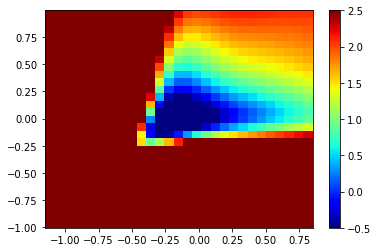

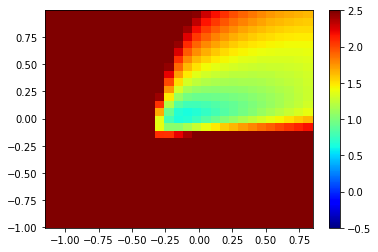

In [95]:
# matplotlib.rcParams['pcolor.shading']

# vmin = np.min(grid_vals_J)
# # vmax = np.max(grid_vals_J)
# vmax = vmin + 8

vmin = -0.5
vmax = 2.5

plt.pcolormesh(x, y, grid_vals_J - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()

plt.figure()
plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()

print(np.min(grid_vals_noJ), np.max(grid_vals_noJ))

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


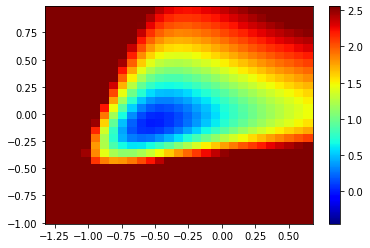

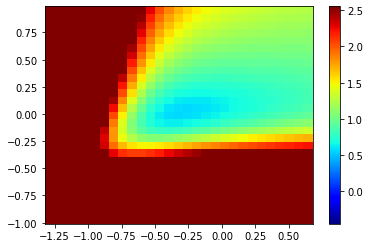

In [42]:
# matplotlib.rcParams['pcolor.shading']

vmin = np.min(grid_vals_J)
# vmax = np.max(grid_vals_J)
vmax = vmin + 3

plt.pcolormesh(x, y, grid_vals_J - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()

plt.figure()
plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()

In [90]:
x0 = x_min

In [24]:
energy_function = {'fun': energy_fun, 'args': ([True])}

proposal_full = {'fun': proposal, 'args': ([2])}

sampling_J = run_Metropolis(x0, proposal_full, energy_function, n_steps=500)

NameError: name 'energy_fun' is not defined

In [92]:
energy_function = {'fun': energy_fun, 'args': ([False])}
sampling_noJ = run_Metropolis(x0, proposal_full, energy_function, n_steps=500)

0
100
200
300
400


Text(0.5, 1.0, 'lambdas without Jeffreys prior')

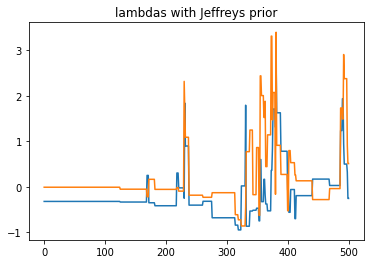

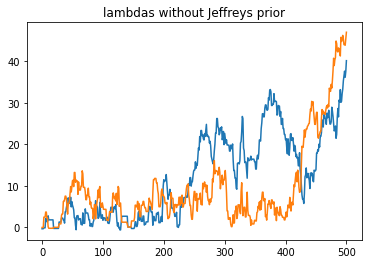

In [66]:
for i in range(2):

    plt.plot(sampling_J[0][:, i], '-')
    # plt.plot(sampling_noJ[0][:, i], '-', label='without Jeffreys prior')
    # plt.legend()

plt.title('lambdas with Jeffreys prior')

# plt.savefig('../Figures/lambdas_J.pdf', format="pdf", bbox_inches="tight")

plt.figure()

for i in range(2):
    plt.plot(sampling_noJ[0][:, i], '-')
    # plt.legend()

plt.title('lambdas without Jeffreys prior')

# plt.savefig('../Figures/lambdas_noJ.pdf', format="pdf", bbox_inches="tight")

av. acceptance: with J.0.094; without J.0.74


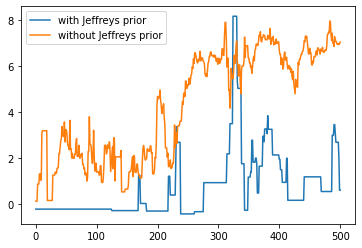

In [67]:
plt.plot(sampling_J[1], '-', label='with Jeffreys prior')
plt.plot(sampling_noJ[1], '-', label='without Jeffreys prior')
plt.legend()

s = 'av. acceptance: with J.' + str(sampling_J[-1]) + '; without J.' + str(sampling_noJ[-1])
# plt.text(2000, 0, s=s)

print(s)

# plt.savefig('../Figures/energies.pdf', format="pdf", bbox_inches="tight")


### 4. sampling force-field corrections

(only $\beta$ is finite, $\beta=1$)

In [20]:
result = minimizer(data, regularization={'force_field_reg': 'KL divergence'}, beta=0.1)

New evaluation:
loss:  2.554225070540097
gradient:  [-4.05408921  0.54084188] 

New evaluation:
loss:  1.1543698717516433
gradient:  [-0.1635316   0.34756898] 

New evaluation:
loss:  1.0429626823587863
gradient:  [-0.1180894   0.26697723] 

New evaluation:
loss:  0.8738454660801004
gradient:  [-0.06187775  0.14678434] 

New evaluation:
loss:  0.7682967021313136
gradient:  [-0.03171388  0.06761513] 

New evaluation:
loss:  0.7267741633475326
gradient:  [-0.01958299  0.02874922] 

New evaluation:
loss:  0.7138784736985478
gradient:  [-0.01481472  0.00863437] 

New evaluation:
loss:  0.7119363014481656
gradient:  [-0.01327717  0.00056677] 

New evaluation:
loss:  0.7118023430855789
gradient:  [-0.01277416 -0.00129675] 

New evaluation:
loss:  0.7117349840593047
gradient:  [-0.01234695 -0.00193724] 

New evaluation:
loss:  0.7116123272156744
gradient:  [-0.01159959 -0.00251015] 

New evaluation:
loss:  0.7113897810804859
gradient:  [-0.01031217 -0.00304577] 

New evaluation:
loss:  0.7110

In [21]:
pars = result.pars

pars

array([ 1.82233631, -4.2176501 ])

In [27]:
deltap = 10

pars1 = np.arange(pars[0] - deltap, pars[0] + deltap, 0.3)
pars2 = np.arange(pars[1] - deltap, pars[1] + deltap, 0.3)

loss = {}
density = {}

for p1 in pars1:
    print(p1)

    loss[p1] = {}
    density[p1] = {}

    for p2 in pars2:
        out = loss_function(np.array([p1, p2]), data, regularization={'force_field_reg': 'KL divergence'}, beta=0.1, if_save=True)
        
        loss[p1][p2] = out.loss
        density[p1][p2] = local_density((fun_forces, np.array([p1, p2]), data.mol[name_mol].f, data.mol[name_mol].g), out.weights_new[name_mol])


-8.177663687306813
-7.877663687306813
-7.5776636873068135
-7.277663687306814
-6.977663687306814
-6.677663687306814
-6.377663687306814
-6.077663687306814
-5.777663687306815
-5.477663687306815
-5.177663687306815
-4.877663687306815
-4.577663687306815
-4.2776636873068155
-3.9776636873068156
-3.677663687306816
-3.377663687306816
-3.077663687306816
-2.7776636873068163
-2.4776636873068165
-2.1776636873068167
-1.8776636873068169
-1.577663687306817
-1.2776636873068172
-0.9776636873068174
-0.6776636873068176
-0.37766368730681776
-0.07766368730681883
0.22233631269318188
0.5223363126931826
0.8223363126931815
1.1223363126931805
1.4223363126931812
1.7223363126931819
2.022336312693181
2.3223363126931797
2.6223363126931805
2.922336312693181
3.22233631269318
3.522336312693179
3.8223363126931797
4.1223363126931805
4.422336312693179
4.722336312693178
5.022336312693179
5.32233631269318
5.622336312693179
5.922336312693178
6.222336312693178
6.522336312693179
6.822336312693178
7.122336312693177
7.42233631269

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C i

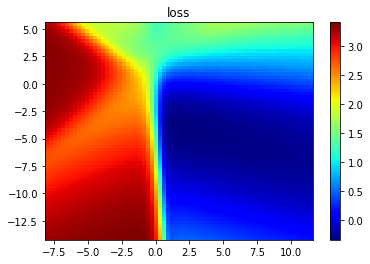

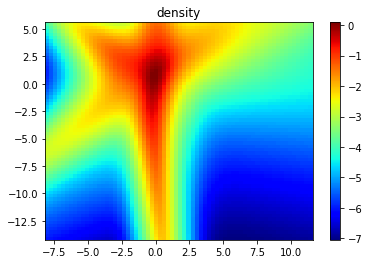

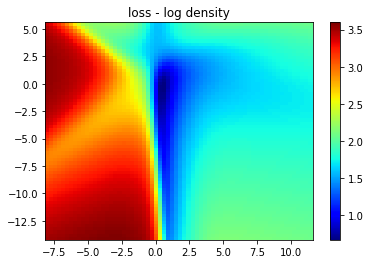

In [48]:
# loss = np.array([[loss[l1][l2] for l1 in pars1] for l2 in pars2])
# density = np.array([[density[l1][l2][0] for l1 in pars1] for l2 in pars2])

plt.figure()
plt.title('loss')
plt.pcolormesh(pars1, pars2, np.log(loss), cmap='jet')
plt.colorbar()

plt.figure()
plt.title('density')
plt.pcolormesh(pars1, pars2, -np.log(density), cmap='jet')
plt.colorbar()

plt.figure()
plt.title('loss - log density')
plt.pcolormesh(pars1, pars2, np.log(loss - np.log(density)), cmap='jet')
plt.colorbar()

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


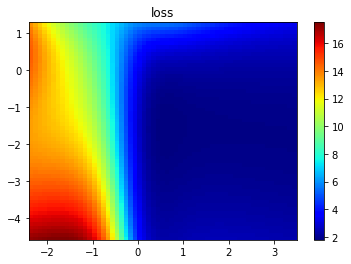

In [67]:
flatten = lambda out, s: np.array([[vars(out[l1][l2])[s] for l1 in pars1] for l2 in pars2])

loss = flatten(out, 'loss')

plt.figure()
plt.title('loss')
plt.pcolormesh(pars1, pars2, loss, cmap='jet')
plt.colorbar()


In [55]:
out = loss_function(pars, data, regularization={'force_field_reg': 'KL divergence'}, beta=0.1, if_save=True)

out.loss

DeviceArray(1.78162992, dtype=float64)

In [13]:
infos

{'global': {'path_directory': '../../3_alphabetagamma/MDRefine/tests/DATA_test',
  'system_names': ['AAAA', 'CAAU'],
  'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J'],
  'forward_qs': ['backbone1_gamma', 'backbone2_beta_epsilon', 'sugar'],
  'forward_coeffs': 'original_fm_coeffs',
  'forward_model': <function __main__.forward_model_fun(fm_coeffs, forward_qs, selected_obs=None)>,
  'names_ff_pars': ['sin alpha', 'cos alpha'],
  'ff_correction': <function __main__.ff_correction(pars, f)>}}

In [49]:
x0 = pars

def proposal(x0, dx=0.01):
    x_new = x0 + dx*np.random.normal(size=len(x0))
    return x_new

proposal_full = {'fun': proposal, 'args': ([2.0])}

name_mol = data.properties.system_names[0]

ff_correction = data.mol[name_mol].ff_correction
fun_forces = jax.jacfwd(ff_correction, argnums=0)


def energy_fun(pars, which_measure):
    
    out = loss_function(pars, data, regularization={'force_field_reg': 'KL divergence'}, beta=0.1, if_save=True)
    
    energy = out.loss  # which is loss_explicit if alpha is infinite

    av_g = unwrap_2dict(out.av_g)[0]

    if which_measure == 'jeffreys' or which_measure == 'dirichlet':
        measure, cov = local_density((fun_forces, pars, data.mol[name_mol].f), out.weights_new[name_mol], which_measure=which_measure)
        energy -= np.log(measure)
    elif which_measure == 'average':
        measure, cov = local_density((fun_forces, pars, data.mol[name_mol].f, data.mol[name_mol].g), out.weights_new[name_mol])
        energy -= np.log(measure)
    
    return energy, av_g

In [53]:
energy_function = {'fun': energy_fun, 'args': ([None])}
sampling_J = run_Metropolis(x0, proposal_full, energy_function, n_steps=1000)

0
100
200
300
400
500
600
700
800
900


In [54]:
traj = sampling_J[0]
ene = sampling_J[1]
quantities = sampling_J[2]
av_alpha = sampling_J[3]

[[2.73197356 1.97386258 8.03699525 4.80013673 1.79051993 3.91633337]
 [2.73197356 1.97386258 8.03699525 4.80013673 1.79051993 3.91633337]
 [2.73197356 1.97386258 8.03699525 4.80013673 1.79051993 3.91633337]
 ...
 [2.80068858 1.88046419 8.21241021 5.06619999 1.81953341 3.81541441]
 [2.87973825 1.91518799 8.28868481 5.1728136  1.76571306 3.76124947]
 [2.72141299 1.87064506 8.12130534 4.92174397 1.83373407 3.87473191]]


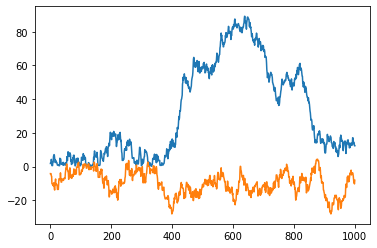

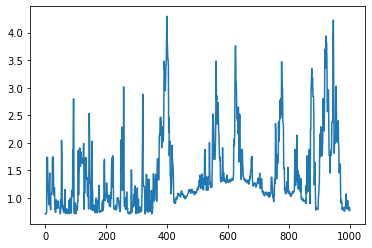

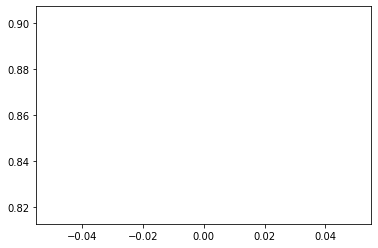

In [55]:
plt.plot(traj, '-')

plt.figure()
plt.plot(ene, '-')
print(av_alpha)

plt.figure()
plt.plot(quantities, '-')

[[2.73197356 1.97386258 8.03699525 4.80013673 1.79051993 3.91633337]
 [2.73197356 1.97386258 8.03699525 4.80013673 1.79051993 3.91633337]
 [2.73197356 1.97386258 8.03699525 4.80013673 1.79051993 3.91633337]
 ...
 [3.24568329 2.29554293 8.6085693  6.03345096 1.20381996 3.4476992 ]
 [3.24568329 2.29554293 8.6085693  6.03345096 1.20381996 3.4476992 ]
 [3.24568329 2.29554293 8.6085693  6.03345096 1.20381996 3.4476992 ]]


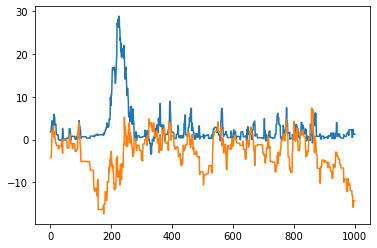

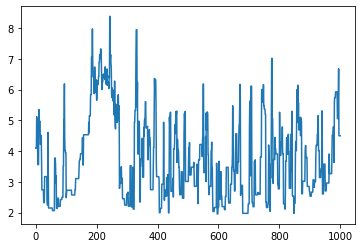

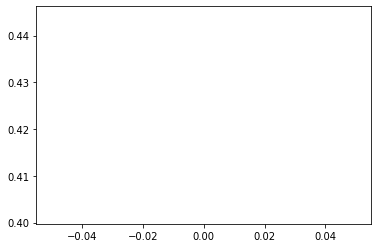

In [52]:
plt.plot(traj, '-')

plt.figure()
plt.plot(ene, '-')
print(av_alpha)

plt.figure()
plt.plot(quantities, '-')

[[2.73197356 1.97386258 8.03699525 4.80013673 1.79051993 3.91633337]
 [2.73197356 1.97386258 8.03699525 4.80013673 1.79051993 3.91633337]
 [2.73197356 1.97386258 8.03699525 4.80013673 1.79051993 3.91633337]
 ...
 [2.29908762 2.07399332 7.03320251 4.114331   3.0160576  4.6276852 ]
 [2.29908762 2.07399332 7.03320251 4.114331   3.0160576  4.6276852 ]
 [2.34159427 2.07950939 7.15915218 4.22940385 2.80121152 4.50891362]]


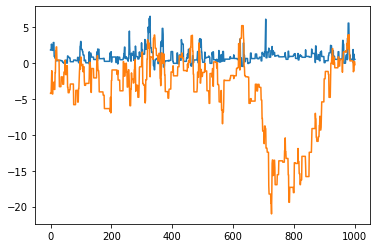

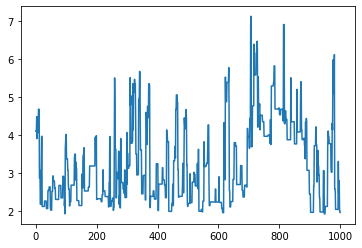

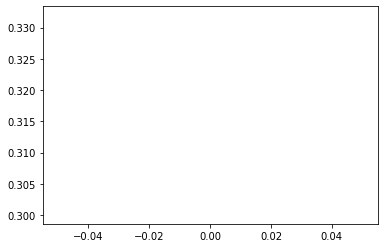

In [44]:
plt.plot(traj, '-')

plt.figure()
plt.plot(ene, '-')
print(av_alpha)

plt.figure()
plt.plot(quantities, '-')

0.958


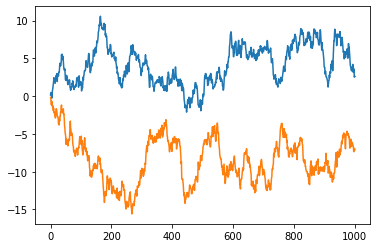

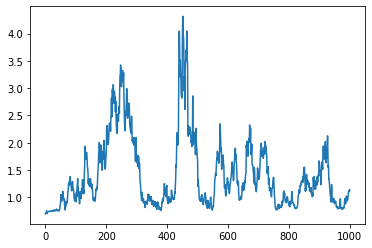

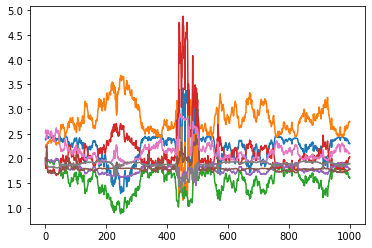

In [47]:
plt.plot(traj, '-')

plt.figure()
plt.plot(ene, '-')
print(av_alpha)

plt.figure()
plt.plot(quantities, '-')

0.862


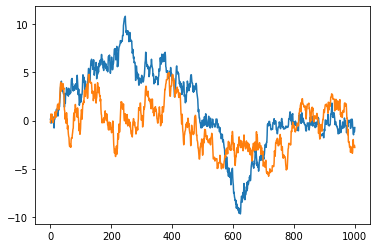

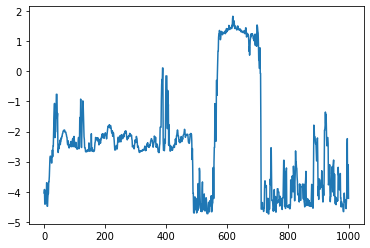

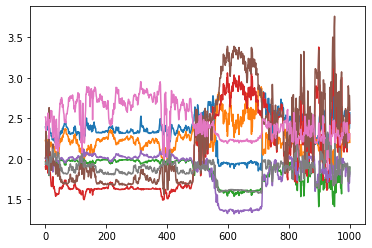

In [44]:
plt.plot(traj, '-')

plt.figure()
plt.plot(ene, '-')
print(av_alpha)

plt.figure()
plt.plot(quantities, '-')

0.792


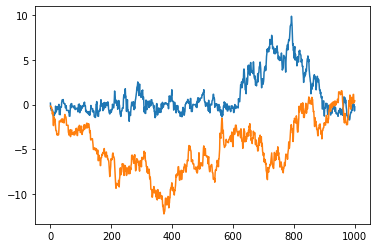

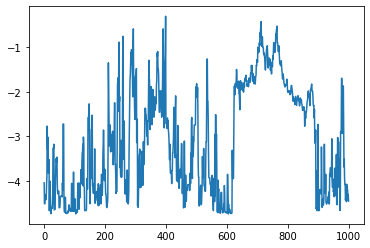

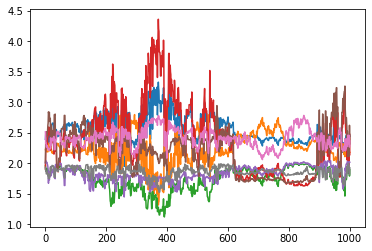

In [41]:
plt.plot(traj, '-')

plt.figure()
plt.plot(ene, '-')
print(av_alpha)

plt.figure()
plt.plot(quantities, '-')

since we have just 2 coefficients, we can plot the posterior

In [71]:
n = 30
delta = 10

x = np.linspace(x0[0] - delta, x0[1] + delta, n)
y = np.linspace(x0[1] - delta, x0[1] + delta, n)

grid = np.meshgrid(x, y)[0]

In [82]:
sh = grid.shape

grid_vals_J = np.zeros(sh)
grid_vals_noJ = np.zeros(sh)
grid_vals_avg = np.zeros((sh[0], sh[1], 8))

name_mol = 'AAAA'

for i in range(sh[0]):
    for j in range(sh[1]):
        out = loss_function(np.array([x[i], y[j]]), data, regularization={'force_field_reg': 'KL divergence'}, beta=0.1, if_save=True)
        grid_vals_noJ[i, j] = out.loss
        grid_vals_avg[i, j, :] = np.array(unwrap_2dict(out.av_g)[0])

        measure, cov = compute_sqrt_det(data.mol[name_mol].g, out.weights_new[name_mol])
        grid_vals_J[i, j] = grid_vals_noJ[i, j] - np.log(measure)


/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


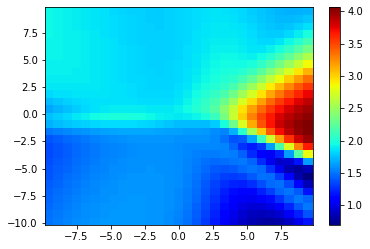

In [90]:
plt.pcolormesh(x, y, grid_vals_avg[:, :, 7], cmap='jet')
plt.colorbar()

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


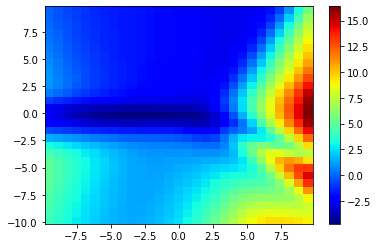

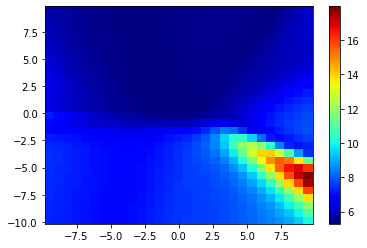

In [73]:
# plt.pcolormesh(x, y, grid_vals_J - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.pcolormesh(x, y, grid_vals_J, cmap='jet')
plt.colorbar()

plt.figure()
# plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet')
plt.colorbar()

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


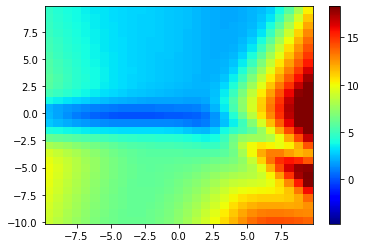

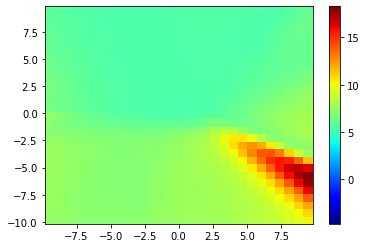

In [74]:
# matplotlib.rcParams['pcolor.shading']

vmin = np.min(grid_vals_J)
vmax = np.max(grid_vals_J)
# vmax = vmin + 8

# vmin = -0.5
# vmax = 2.5

plt.pcolormesh(x, y, grid_vals_J - vmin, cmap='jet', vmin=vmin, vmax=vmax)
# plt.pcolormesh(x, y, grid_vals_J, cmap='jet')
plt.colorbar()

plt.figure()
plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet', vmin=vmin, vmax=vmax)
# plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet')
plt.colorbar()

# print(np.min(grid_vals_noJ), np.max(grid_vals_noJ))